<h1>Multiclass Imbalanced Classification</h1>

In this notebook, i will create a random forest classifier to predict the diabetic type of a person.

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from yellowbrick.classifier import ROCAUC
from ipynb.fs.full.funPyModeling import status, freq_tbl, cat_vars, num_vars
from sklearn import set_config

In [52]:
set_config(display='diagram')

<h3>Data Loading</h3>

In [53]:
data = pd.read_csv("data/diabetes_multi_over.csv", sep = ";")

<h3>Dataset Status</h3>

In [54]:
status(data)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,Pregnancies,444,0.144531,0,0.0,16,float64
1,Glucose,20,0.006510,0,0.0,135,float64
2,BloodPressure,140,0.045573,0,0.0,46,float64
3,SkinThickness,908,0.295573,0,0.0,50,float64
4,Insulin,1496,0.486979,0,0.0,185,float64
5,BMI,44,0.014323,0,0.0,247,float64
6,DiabetesPedigreeFunction,0,0.000000,0,0.0,517,float64
7,Age,0,0.000000,0,0.0,52,int64
8,diabetic_type,0,0.000000,0,0.0,3,object


In this dataset, there are NaNs in 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin' and 'BMI'. Also, there are only one categorical variable ('diabetic_type')

In [55]:
freq_tbl(data.diabetic_type)

,diabetic_type,frequency,percentage,cumulative_perc
0,diabetic,1264,0.411458,0.411458
1,pre-diabetic,1040,0.338542,0.750000
2,normal,768,0.250000,1.000000


In the variable to predict, there are 3 unbalanced classes.

<h3>Data Preparation (Pipeline)</h3>

Target and features separation

In [56]:
x_data = data.drop(['Glucose','diabetic_type'], axis=1)
y_data = data['diabetic_type']

Training set and test set separation

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

In [58]:
# Pipeline creation for cat and num
num_transformer = Pipeline(
    steps=[('num_imputer', SimpleImputer(strategy='median'))])

# Putting all together
all_transformer = ColumnTransformer(
    transformers=[
        ('num_t', num_transformer, num_vars(x_train))])

In [59]:
all_transformer

ColumnTransformer(transformers=[('num_t',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])

<h3>Models Creation</h3>

In [60]:
pipe_rf = Pipeline(steps=[('all_transformer', all_transformer),
                          ('model_rf',        RandomForestClassifier(min_samples_leaf=35, max_depth=5,min_samples_split=60))])

Fitting the pipeline

In [61]:
pipe_rf.fit(x_train, y_train)

Pipeline(steps=[('all_transformer',
                 ColumnTransformer(transformers=[('num_t',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])),
                ('model_rf',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=35,
                                        min_samples_split=60))])

<h3>ROC validation</h3>

C:\Users\Tec\Anaconda3\envs\PythonCPU\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


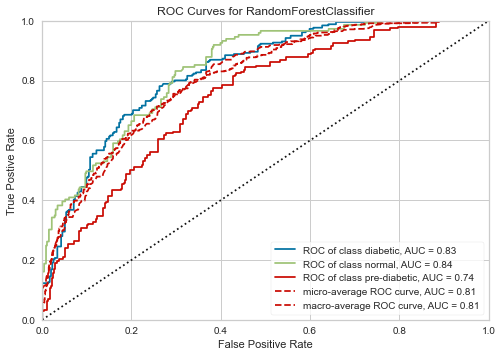

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>

In [62]:
visualizer = ROCAUC(pipe_rf, classes=["diabetic", "normal", "pre-diabetic"])

visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show()  

<h4>From the dataset status, i saw that the variable to predict is highly unbalanced, so, i will try to balance the classes keeping the ROC AUC</h4>

<h3>Undersamplng</h3>

In [63]:
freq_tbl(data.diabetic_type)

,diabetic_type,frequency,percentage,cumulative_perc
0,diabetic,1264,0.411458,0.411458
1,pre-diabetic,1040,0.338542,0.750000
2,normal,768,0.250000,1.000000


Defining the strategy

In [64]:
undersample = RandomUnderSampler(sampling_strategy={'diabetic': 800, 'pre-diabetic': 600, 'normal': 400})

Fit and re-sample

In [65]:
x_under, y_under = undersample.fit_resample(x_train, y_train)

In [66]:
freq_tbl(y_under)

,diabetic_type,frequency,percentage,cumulative_perc
0,diabetic,800,0.444444,0.444444
1,pre-diabetic,600,0.333333,0.777778
2,normal,400,0.222222,1.000000


In [67]:
pipe_rf2 = Pipeline(steps=[('all_transformer', all_transformer),
                          ('model_rf',        RandomForestClassifier(min_samples_leaf=35, max_depth=5,min_samples_split=60))])

In [68]:
pipe_rf2.fit(x_under, y_under)

Pipeline(steps=[('all_transformer',
                 ColumnTransformer(transformers=[('num_t',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])),
                ('model_rf',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=35,
                                        min_samples_split=60))])

<h3>ROC Validation</h3>

C:\Users\Tec\Anaconda3\envs\PythonCPU\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


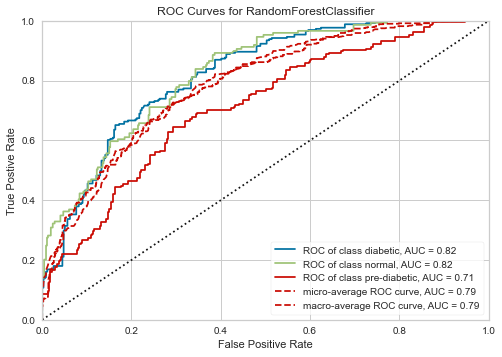

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>

In [69]:
visualizer = ROCAUC(pipe_rf2, classes=["diabetic", "normal", "pre-diabetic"])

visualizer.fit(x_under, y_under)
visualizer.score(x_test, y_test)
visualizer.show()  

<h3>Insights</h3>

In [70]:
len(x_train+y_train)

2457

In [71]:
len(x_under+y_under)

1800

From the previous model, i see that with approximately 27% of the data, i get the same ROC. This is very useful because it saves time.